# Advanced Analytics in Fundraising - Predictive and Descriptive Analytics 
**Group 5:** Fernando Delgado, Mario Serrano and Harikrishnan Gopalakrishnan

## Data Cleaning
**Workflow stages:**

The following notebook goes through the following stages: 

1. Question or problem definition.
2. Cleaning and Describing Data
3. Calculating Train and Test
4. Feature Creation
5. Exporting New Datasets

## Question and problem definition

DSC is an organization that helps non-profit organizations to find donors for their good causes. They have a huge database with candidate donors. DSC now wants to launch a new re-activation campaign where they want to send letters to donors that have been inactive for a long time, hoping that they will donate again. The CEO & Head of Data Analytics (conveniently, this is the same person for this exercise) have to be convinced that your model is better than just randomly selecting donors.

The goal is to convince the CEO & Head of Data Analytics of DSC (fictively) that your model has added value and that it should be used in future campaign.

In [1]:
# Data Analysis
import numpy             as np
import pandas            as pd
import datetime
from datetime            import datetime, timedelta
import statistics        as st

#Visualization
import matplotlib.pyplot as plt

## Acquire Data
We begin by reading in the dataset into Pandas.
campaigns, donors and gifts are our data tables, while 6169 and 7244 are simply our selected targets with which we will train and test the model. 

In [3]:
campaigns = pd.read_csv('../data/raw/campaigns.csv',sep=';')
donors = pd.read_csv('../data/raw/donors.csv',sep=',')
gifts = pd.read_csv('../data/raw/gifts.csv',sep=',')
selection_camp_6169 = pd.read_csv('../data/raw/selection campaign 6169.csv',sep=';')
selection_camp_7244 = pd.read_csv('../data/raw/selection campaign 7244.csv',sep=';')

## Cleaning and Decribing Data
Before we can analyze our data and create a main table we have to analyze each table individually and make the required  data cleaning.

### Campaigns Table 

In [4]:
campaigns.head()

,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [5]:
print(campaigns.shape)
campaigns.dtypes

(367, 4)


campaignID      int64
date           object
lettersSent    object
CostUnit       object
dtype: object

In [6]:
#Change data types and drop extra columns
campaigns['date'] = pd.to_datetime(campaigns['date'])
campaigns = campaigns.drop(['lettersSent','CostUnit'],axis=1)
campaigns.head()

,campaignID,date
0,153,2004-12-13
1,154,2005-01-01
2,180,2005-01-18
3,433,2005-01-29
4,476,2005-12-02


### Gifts table

In [7]:
gifts.head()

,Unnamed: 0,donorID,campaignID,amount,date
0,0,100001,NaN,"12,39",2004-03-23
1,1,100001,1577.0,"12,39",2007-10-11
2,2,100001,1634.0,"6,69",2007-12-28
3,3,100001,1778.0,"24,79",2008-06-14
4,4,100001,1808.0,"7,44",2008-07-09


In [8]:
print(gifts.shape)
gifts.dtypes

(216594, 5)


Unnamed: 0      int64
donorID         int64
campaignID    float64
amount         object
date           object
dtype: object

In [9]:
#merge dates from campaigns
gifts = pd.merge(gifts,campaigns, on ='campaignID',how='left')

In [10]:
#Remove Null Values
gifts.isna().sum()/gifts.shape[0] 

Unnamed: 0    0.000000
donorID       0.000000
campaignID    0.072195
amount        0.000000
date_x        0.000000
date_y        0.072195
dtype: float64

In [11]:
#drop unnamed column
gifts = gifts.drop('Unnamed: 0',axis=1)

#replace nas in date_y as the same data_x
gifts.loc[gifts['date_y'].isna(),'date_y'] = gifts.loc[gifts['date_y'].isna(),'date_x']

#replace commas in amount
gifts['amount'] = gifts['amount'].str.replace(',', '.').astype(float)

gifts.head()

,donorID,campaignID,amount,date_x,date_y
0,100001,NaN,12.39,2004-03-23,2004-03-23
1,100001,1577.0,12.39,2007-10-11,2007-09-10 00:00:00
2,100001,1634.0,6.69,2007-12-28,2007-08-12 00:00:00
3,100001,1778.0,24.79,2008-06-14,2008-05-25 00:00:00
4,100001,1808.0,7.44,2008-07-09,2008-06-22 00:00:00


In [12]:
gifts['amount'].describe()

count    2.165940e+05
mean     5.750712e+01
std      1.011180e+04
min      1.000000e-01
25%      1.000000e+01
50%      2.479000e+01
75%      3.200000e+01
max      4.000000e+06
Name: amount, dtype: float64

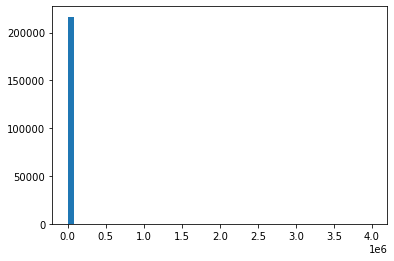

In [186]:
plt.hist(gifts['amount'],bins = 50)
plt.show()

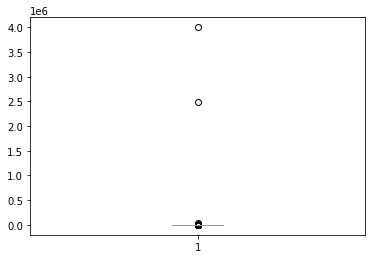

In [187]:
plt.boxplot([gifts['amount']])
plt.show() #high outliers

In [188]:
print(gifts['amount'].quantile(0.995))
gifts.sort_values('amount',ascending=False).head(10) #before removing we check the time since last donation

200.0


,donorID,campaignID,amount,date_x,date_y
153012,123168,NaN,4000000.00,2010-04-26,2010-04-26
141895,120861,1917.0,2479000.00,2008-11-17,2008-10-29 00:00:00
150654,122679,2417.0,30000.00,2010-07-04,2010-06-26 00:00:00
182959,130966,1377.0,12394.68,2007-04-21,2007-02-04 00:00:00
21410,102552,3785.0,5000.00,2014-05-03,2014-04-21 00:00:00
172833,128065,NaN,4000.00,2010-03-12,2010-03-12
53184,105960,NaN,3718.40,2004-11-16,2004-11-16
184130,131307,NaN,3600.00,2012-11-12,2012-11-12
210918,142006,NaN,3198.00,2016-02-10,2016-02-10
79841,109635,2360.0,2500.00,2010-03-30,2010-03-25 00:00:00


There are many outliers, but we dont remove them for now.

In [13]:
#fix date formats
gifts['date_x'] = pd.to_datetime(gifts['date_x'])
gifts['date_y'] = pd.to_datetime(gifts['date_y'])

gifts['date_x'].describe()

<ipython-input-13-4b380b732191>:5: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  gifts['date_x'].describe()


count                  216594
unique                   6113
top       2015-03-17 00:00:00
freq                      287
first     2000-06-05 00:00:00
last      2020-01-04 00:00:00
Name: date_x, dtype: object

(array([   566.,   1179.,   1038.,    998.,   2748.,   6269.,   4512.,
          2968.,   7651.,  12942., 142355.,   4106.,   6556.,   6415.,
          6701.,   2811.,   3065.,   1101.,   2271.,    342.]),
 array([-321.  , -289.25, -257.5 , -225.75, -194.  , -162.25, -130.5 ,
         -98.75,  -67.  ,  -35.25,   -3.5 ,   28.25,   60.  ,   91.75,
         123.5 ,  155.25,  187.  ,  218.75,  250.5 ,  282.25,  314.  ]),
 <BarContainer object of 20 artists>)

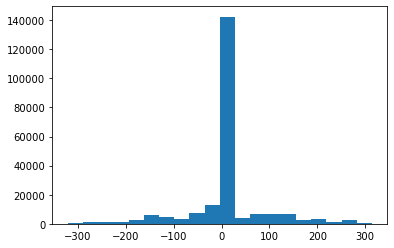

In [14]:
#calculate how many days after campaign launch people usually donate
gifts['days_after'] = gifts['date_x']- gifts['date_y']
gifts['days_after'] = gifts['days_after'].astype(str).str.replace(' days', '').astype(float)
plt.hist(gifts['days_after'],bins = 20)

More than 90% of the people donate within the first 30 days of the campaign date.

In [16]:
selection_camp_6169.shape

(34888, 1)

In [17]:
#identify dates for train and test campaigns

date_6169 = gifts.loc[gifts['campaignID']==6169,'date_y'].iloc[1,]
date_7244 = gifts.loc[gifts['campaignID']==7244,'date_y'].iloc[1,]

## Donors Table


**Which features are available in the dataset?**

In [18]:
print(donors.columns.values)

['Unnamed: 0' 'donorID' 'zipcode' 'province' 'region' 'gender' 'language'
 'dateOfBirth']


**Which features are categorical?**

- Categorical: language, gender, region, province.

**Which features are numerical?**

- Continous: dateOfBirth

In [19]:
print(gifts.shape)
gifts.dtypes

(216594, 6)


donorID                int64
campaignID           float64
amount               float64
date_x        datetime64[ns]
date_y        datetime64[ns]
days_after           float64
dtype: object

#### Cleaning Data

- We drop an extra column 
- Fix 32 null genders by changing them to the mode, which in this case is male. 
- Drop 2 remainig null rows
- Change zipcodes to integers
- We will later on use Birth year to calculate the Age of the donor at the time of the campaign

In [20]:
#Drop column Unnamed: 0
donors = donors.drop(columns = ['Unnamed: 0'])

#Fix 32 Null genders with gender mode
notnullgender = donors[donors.gender.notnull()]
gendermode = st.mode(notnullgender['gender'])
donors['gender'] = donors['gender'].fillna(gendermode)

#Drop 2 remaining nulls
donors = donors.dropna()

#Cast zipcode as int
donors.zipcode = donors.zipcode.astype(int)

#Get Birth Year
donors['birth_year'] = donors['dateOfBirth'].astype(str).str[-4:].astype(int)

#Drop dateOfBirth
donors = donors.drop(columns=['dateOfBirth'])

donors.head()

,donorID,zipcode,province,region,gender,language,birth_year
0,100001,1861,Flemish Brabant,Flanders,F,NL,1967
1,100002,2260,Antwerp,Flanders,M,NL,1952
2,100003,1780,Flemish Brabant,Flanders,M,NL,1986
3,100004,1020,Brussels,Brussels,F,FR,1952
4,100005,1020,Brussels,Brussels,F,FR,1986


**Which features may contain errors or typos?**
- We noticed there are only 4 people that speak english and decide to replace them by the most preferred language.
- Fix province column by capitalization

In [23]:
#Only 4 People speak English
donors[donors.language == 'EN']

#We change them to the majority language: Dutch
donors.loc[donors['language']== 'EN', 'language'] = 'NL'

#Fix Capitalized values in province
donors.loc[donors['province']=='ANTWERP', 'province'] = 'Antwerp'

### Encoding Categorical Data
We use One Hot encoding for gender, laguage, province and region:
- gender: 1 if Male 0 if Female
- language: 1 if Dutch 0 if French
- region: if Flandres and Wallonia are false, then its Brussels
- Province: 1 if it belong to the named province

In [24]:
#One Hot encoding
gender = pd.get_dummies(donors['gender'],drop_first = True)
language = pd.get_dummies(donors['language'],drop_first = True)
region = pd.get_dummies(donors['region'],drop_first = True)
province = pd.get_dummies(donors['province'],drop_first = False)

donors = pd.concat([donors, gender, language, region, province], axis=1)

#Drop DateofBirth and gender column
donors = donors.drop(columns=['gender', 'language'])

#Renaming columns
donors = donors.rename(columns={'M': 'gender', 'NL': 'language'})

In [25]:
donors.head()

,donorID,zipcode,province,region,birth_year,gender,language,Flanders,Wallonia,Antwerp,Brussels,East Flanders,Flemish Brabant,Hainaut,Liege,Limburg,Luxembourg,Namur,Walloon Brabant,West Flanders
0,100001,1861,Flemish Brabant,Flanders,1967,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0
1,100002,2260,Antwerp,Flanders,1952,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0
2,100003,1780,Flemish Brabant,Flanders,1986,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0
3,100004,1020,Brussels,Brussels,1952,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,100005,1020,Brussels,Brussels,1986,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


**We perfom some additional visualization for further understanding of our dataset:**

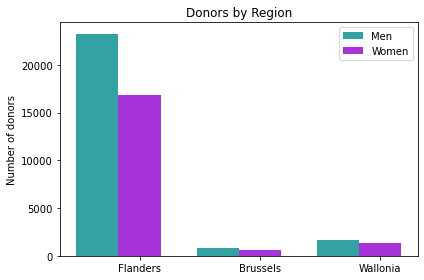

In [26]:
# data to plot
n_groups = 3

flanders = donors[donors['region']=='Flanders']
maleflanders = flanders.gender[flanders['gender']==1].count()
femaleflanders = flanders.gender[flanders['gender']==0].count()

brussels = donors[donors['region']=='Brussels']
malebrussels = brussels.gender[brussels['gender']==1].count()
femalebrussels = brussels.gender[brussels['gender']==0].count()

wallonia = donors[donors['region']=='Wallonia']
malewallonia = wallonia.gender[wallonia['gender']==1].count()
femalewallonia = wallonia.gender[wallonia['gender']==0].count()

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, (maleflanders, malebrussels, malewallonia), bar_width,
alpha=opacity,
color='darkcyan',
label='Men')

rects2 = plt.bar(index + bar_width, (femaleflanders, femalebrussels, femalewallonia), bar_width,
alpha=opacity,
color='darkviolet',
label='Women')

plt.ylabel('Number of donors')
plt.title('Donors by Region')
plt.xticks(index + bar_width, ('Flanders', 'Brussels', 'Wallonia'))
plt.legend()

plt.tight_layout()
plt.show()

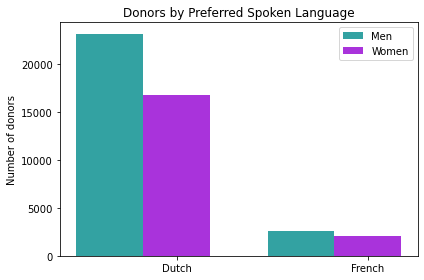

In [27]:
# data to plot
n_groups = 2

dutch = donors[donors['language']==1]
maledutch = dutch.gender[dutch['gender']==1].count()
femaledutch = dutch.gender[dutch['gender']==0].count()

french = donors[donors['language']==0]
malefrench = french.gender[french['gender']==1].count()
femalefrench = french.gender[french['gender']==0].count()

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, (maledutch, malefrench), bar_width,
alpha=opacity,
color='darkcyan',
label='Men')

rects2 = plt.bar(index + bar_width, (femaledutch, femalefrench), bar_width,
alpha=opacity,
color='darkviolet',
label='Women')

plt.ylabel('Number of donors')
plt.title('Donors by Preferred Spoken Language')
plt.xticks(index + bar_width, ('Dutch', 'French'))
plt.legend()

plt.tight_layout()
plt.show()

**Finally, we remove the last columns that we will not use for the base-table**

In [28]:
#drop variables that are not going to be used
donors = donors.drop(['zipcode'],axis=1)
donors.head()

,donorID,province,region,birth_year,gender,language,Flanders,Wallonia,Antwerp,Brussels,East Flanders,Flemish Brabant,Hainaut,Liege,Limburg,Luxembourg,Namur,Walloon Brabant,West Flanders
0,100001,Flemish Brabant,Flanders,1967,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0
1,100002,Antwerp,Flanders,1952,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0
2,100003,Flemish Brabant,Flanders,1986,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0
3,100004,Brussels,Brussels,1952,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,100005,Brussels,Brussels,1986,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## Creating Train and Test

### Create initial test and train from dates

In [29]:
#convert Nas in campaign ID to 1 adn identify

gifts['campaignID_missing'] = 0
gifts.loc[gifts['campaignID'].isna(),'campaignID_missing'] = 1

gifts.loc[gifts['campaignID'].isna(),'campaignID'] = 1

gifts.head()

,donorID,campaignID,amount,date_x,date_y,days_after,campaignID_missing
0,100001,1.0,12.39,2004-03-23,2004-03-23,0.0,1
1,100001,1577.0,12.39,2007-10-11,2007-09-10,31.0,0
2,100001,1634.0,6.69,2007-12-28,2007-08-12,138.0,0
3,100001,1778.0,24.79,2008-06-14,2008-05-25,20.0,0
4,100001,1808.0,7.44,2008-07-09,2008-06-22,17.0,0


We use information from 15 years before ont month the start date of each campaign.
 - **Train Set:** Campaign = 6169 15 years before 2018-03-09
 - **Test Set:** Campaign = 7244 15 years before 2019-05-18
 

In [34]:
#subset train data for dates before 2018-03-10 and we could see if we select only info after certain period too

g_train = gifts[(gifts['date_x']<(date_6169)-timedelta(days=30)) & (gifts['date_x']>(date_6169-timedelta(days=365*15)))]
print(g_train.shape)

g_test = gifts[(gifts['date_x']<(date_7244)-timedelta(days=30)) & (gifts['date_x']>(date_7244-timedelta(days=365*15)))]
print(g_test.shape)


(204377, 7)
(211477, 7)


In [35]:
#Save preprocessed gifts and donors data

gifts.to_csv(r'../data/interim/gifts_preprocessed.csv',index=False)

donors.to_csv(r'../data/interim/donors_preprocessed.csv',index=False)


## First work with TRAIN

In [36]:
print(g_train['campaignID'].nunique())
print(g_train['donorID'].nunique())

324
44551


In [38]:
#count of total number of donations per donor
camp_donor = g_train.groupby('donorID')['campaignID'].agg('count')

#count of unique campaigns per donor
camp_donor_uni = g_train.groupby('donorID')['campaignID'].agg('nunique')
camp_donor_uni = pd.DataFrame(camp_donor_uni).rename(columns={'campaignID':'campaignID_uni'})

In [39]:
#monetary values of donated amount 
donor_total = pd.DataFrame(g_train.groupby('donorID')['amount'].agg(['sum','min','max']))
donor_total = donor_total.rename(columns={'sum':'sum_amount','min':'min_amount','max':'max_amount'})
donor_total.head()

,sum_amount,min_amount,max_amount
donorID,,,
100001,178.49,6.69,30.00
100002,20.00,20.00,20.00
100003,11.00,3.00,5.00
100004,716.22,24.79,49.58
100005,9.96,2.48,5.00


In [40]:
#merge into only one table 
donor_gift = pd.merge(camp_donor,camp_donor_uni, on='donorID')
donor_gift = pd.merge(donor_gift,donor_total, on='donorID')
donor_gift['avg_don'] = donor_gift['sum_amount']/donor_gift['campaignID']
donor_gift.shape

(44551, 6)

In [42]:
#get last donation date for each donor
donor_last_date = g_train.groupby('donorID')['date_x'].agg('max')
donor_gift = pd.merge(donor_gift,donor_last_date, on='donorID')
donor_gift = donor_gift.rename(columns={'date_x':'date_last_don'})
donor_gift.head()

(44551, 7)

Ratio of donations: total number of campaigns donated by donor over total unique campaigns

In [44]:
#ratio of donations

donor_gift['ratio_don'] = donor_gift['campaignID']/g_train['campaignID'].nunique()
donor_gift['ratio_don'].describe()

count    44551.000000
mean         0.014159
std          0.025746
min          0.003086
25%          0.003086
50%          0.006173
75%          0.015432
max          0.734568
Name: ratio_don, dtype: float64

In [45]:
#if donated more than once per campaign 

donor_gift['donated_more_one'] = 0
donor_gift.loc[donor_gift['campaignID']>1,'donated_more_one'] = 1
donor_gift['donated_more_one'].value_counts()

1    25878
0    18673
Name: donated_more_one, dtype: int64

In [46]:
#if donated more than 3 times in general 

donor_gift['donated_more_five'] = 0
donor_gift.loc[donor_gift['campaignID_uni']>5,'donated_more_five'] = 1
donor_gift['donated_more_five'].value_counts()

0    34960
1     9591
Name: donated_more_five, dtype: int64

In [47]:
#create a variable to count how many time a donor donated 30 or more euros 
g_train['more_30'] = 0
g_train.loc[g_train['amount']>=30,'more_30'] = 1
more30 = g_train.groupby('donorID')['more_30'].agg('sum')


<ipython-input-47-378de1065483>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_train['more_30'] = 0
C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [48]:
donor_gift = pd.merge(donor_gift,more30,on='donorID')
donor_gift.shape

(44551, 11)

In [49]:
donor_gift = donor_gift.rename(columns={'campaignID':'number_don','campaignID_uni':'uni_campaigns','max':'max_amount'})
donor_gift.head()

,number_don,uni_campaigns,sum_amount,min_amount,max_amount,avg_don,date_last_don,ratio_don,donated_more_one,donated_more_five,more_30
donorID,,,,,,,,,,,
100001,12,12,178.49,6.69,30.00,14.874167,2011-12-30,0.037037,1,1,1
100002,1,1,20.00,20.00,20.00,20.000000,2015-01-10,0.003086,0,0,0
100003,3,3,11.00,3.00,5.00,3.666667,2017-09-16,0.009259,1,0,0
100004,26,26,716.22,24.79,49.58,27.546923,2011-06-03,0.080247,1,1,10
100005,3,3,9.96,2.48,5.00,3.320000,2016-10-26,0.009259,1,0,0


In [51]:
g_train.head()

,donorID,campaignID,amount,date_x,date_y,days_after,campaignID_missing
0,100001,1.0,12.39,2004-03-23,2004-03-23,0.0,1
1,100001,1577.0,12.39,2007-10-11,2007-09-10,31.0,0
2,100001,1634.0,6.69,2007-12-28,2007-08-12,138.0,0
3,100001,1778.0,24.79,2008-06-14,2008-05-25,20.0,0
4,100001,1808.0,7.44,2008-07-09,2008-06-22,17.0,0


In [52]:
#g_train = g_train.drop('more_30',axis=1)
#g_train.head()

Get how much they donated in the selected campaigns and to create targets.
   - Targets are people that donated 30 or more euros

In [55]:
# merge the selected campaigns people

#only leave the selected ones
gifts_6169 = pd.merge(selection_camp_6169,gifts, on = 'donorID', how = 'left')

print(gifts_6169.shape)
print(selection_camp_6169.shape)

print(gifts_6169['donorID'].nunique())
print(selection_camp_6169['donorID'].nunique())


(151752, 7)
(34888, 1)
34888
34888


In [56]:
#identify donations for campaign
don_6169 = gifts_6169[gifts_6169['campaignID']==6169]

#we get the sum for each campaign to see if they donated more than 30

don_6169_g = pd.DataFrame(don_6169.groupby('donorID')['amount'].agg('sum'))

don_6169_g = don_6169_g.rename(columns={'amount':'amount_6169'})

print(don_6169_g.shape)
print(don_6169_g.head())


(1191, 1)
         amount_6169
donorID             
100023          15.0
100126         123.0
100253         120.0
100279          75.0
100320         135.0


In [57]:
donor_gift = pd.merge(donor_gift,don_6169_g, on ='donorID',how='left')
donor_gift.loc[donor_gift['amount_6169'].isna(),'amount_6169'] = 0
donor_gift.head()

,number_don,uni_campaigns,sum_amount,min_amount,max_amount,avg_don,date_last_don,ratio_don,donated_more_one,donated_more_five,more_30,amount_6169
donorID,,,,,,,,,,,,
100001,12,12,178.49,6.69,30.00,14.874167,2011-12-30,0.037037,1,1,1,0.0
100002,1,1,20.00,20.00,20.00,20.000000,2015-01-10,0.003086,0,0,0,0.0
100003,3,3,11.00,3.00,5.00,3.666667,2017-09-16,0.009259,1,0,0,0.0
100004,26,26,716.22,24.79,49.58,27.546923,2011-06-03,0.080247,1,1,10,0.0
100005,3,3,9.96,2.48,5.00,3.320000,2016-10-26,0.009259,1,0,0,0.0


**Create target variable:**
     1 if donated 30 or more and 0 otherwise

In [59]:
donor_gift['target_6169'] = 0
donor_gift.loc[donor_gift['amount_6169']>=30,'target_6169'] = 1
donor_gift = donor_gift.drop('amount_6169',axis=1)

donor_gift.head()

,number_don,uni_campaigns,sum_amount,min_amount,max_amount,avg_don,date_last_don,ratio_don,donated_more_one,donated_more_five,more_30,target_6169
donorID,,,,,,,,,,,,
100001,12,12,178.49,6.69,30.00,14.874167,2011-12-30,0.037037,1,1,1,0
100002,1,1,20.00,20.00,20.00,20.000000,2015-01-10,0.003086,0,0,0,0
100003,3,3,11.00,3.00,5.00,3.666667,2017-09-16,0.009259,1,0,0,0
100004,26,26,716.22,24.79,49.58,27.546923,2011-06-03,0.080247,1,1,10,0
100005,3,3,9.96,2.48,5.00,3.320000,2016-10-26,0.009259,1,0,0,0


In [94]:
#create a dummy to identify people that donated more than 95% of the donors 
p95 = donor_gift['sum_amount'].quantile(0.95)

donor_gift['sup_95'] = 0
donor_gift.loc[donor_gift['sum_amount']>=p95,'sup_95'] = 1

donor_gift['sup_95'].value_counts()

0    33001
1     1737
Name: sup_95, dtype: int64

In [95]:
print(donor_gift.shape)
print(selection_camp_6169.shape)

(34738, 14)
(34888, 1)


In [76]:
selection_camp_6169[~selection_camp_6169['donorID'].isin(donor_gift['donorID'])]

,donorID
57,100081
245,100325
357,100459
360,100462
367,100472
...,...
22469,126862
23185,255488
26403,263382
27299,265584


In [87]:
gifts[gifts['donorID']==255488]

,donorID,campaignID,amount,date_x,date_y,days_after,campaignID_missing
216587,255488,6169.0,18.0,2018-09-21,2018-04-09,165.0,0


Last two steps were made to check why are there some people that is getting eliminated from the selected donors. 

We found out that the unmatched donors are people that do not correspond to our timeline analysis.
In this case people with a donation date from mor than 15 ago and a small amount of people that donated within the 30 days gap before the campaign date.

In [96]:
#filter only selected
donor_gift = pd.merge(selection_camp_6169,donor_gift, on ='donorID',how='inner')
print(donor_gift.shape)
print(selection_camp_6169.shape)


(34738, 14)
(34888, 1)


In [98]:
#store donor_gift table as train

train = donor_gift
train.head()

,donorID,number_don,uni_campaigns,sum_amount,min_amount,max_amount,avg_don,date_last_don,ratio_don,donated_more_one,donated_more_five,more_30,target_6169,sup_95
0,100001,12,12,178.49,6.69,30.00,14.874167,2011-12-30,0.037037,1,1,1,0,0
1,100002,1,1,20.00,20.00,20.00,20.000000,2015-01-10,0.003086,0,0,0,0,0
2,100004,26,26,716.22,24.79,49.58,27.546923,2011-06-03,0.080247,1,1,10,0,1
3,100008,3,3,124.37,24.79,50.00,41.456667,2011-10-28,0.009259,1,0,2,0,0
4,100009,19,19,326.78,7.44,25.00,17.198947,2012-03-25,0.058642,1,1,0,0,0


## Second work with TEST

We repeat all the steps made for the train set but with the different timeline of information and with a new target for campaign 7244.

In [99]:
#count of campaigns donated
camp_donor = g_test.groupby('donorID')['campaignID'].agg('count')

#unique campaigns
camp_donor_uni = g_test.groupby('donorID')['campaignID'].agg('nunique')
camp_donor_uni = pd.DataFrame(camp_donor_uni).rename(columns={'campaignID':'campaignID_uni'})

In [100]:
donor_total = pd.DataFrame(g_test.groupby('donorID')['amount'].agg(['sum','min','max']))
donor_total = donor_total.rename(columns={'sum':'sum_amount','min':'min_amount','max':'max_amount'})
donor_total.head()

,sum_amount,min_amount,max_amount
donorID,,,
100001,166.10,6.69,30.00
100002,20.00,20.00,20.00
100003,42.00,3.00,5.00
100004,716.22,24.79,49.58
100005,24.96,2.48,10.00


In [101]:
donor_gift = pd.merge(camp_donor,camp_donor_uni, on='donorID')
donor_gift = pd.merge(donor_gift,donor_total, on='donorID')
donor_gift['avg_don'] = donor_gift['sum_amount']/donor_gift['campaignID']
donor_gift.head()

,campaignID,campaignID_uni,sum_amount,min_amount,max_amount,avg_don
donorID,,,,,,
100001,11,11,166.10,6.69,30.00,15.100000
100002,1,1,20.00,20.00,20.00,20.000000
100003,11,11,42.00,3.00,5.00,3.818182
100004,26,26,716.22,24.79,49.58,27.546923
100005,5,5,24.96,2.48,10.00,4.992000


In [102]:
donor_last_date = g_test.groupby('donorID')['date_x'].agg('max')
donor_gift = pd.merge(donor_gift,donor_last_date, on='donorID')
donor_gift = donor_gift.rename(columns={'date_x':'date_last_don'})
donor_gift.head()

,campaignID,campaignID_uni,sum_amount,min_amount,max_amount,avg_don,date_last_don
donorID,,,,,,,
100001,11,11,166.10,6.69,30.00,15.100000,2011-12-30
100002,1,1,20.00,20.00,20.00,20.000000,2015-01-10
100003,11,11,42.00,3.00,5.00,3.818182,2019-05-06
100004,26,26,716.22,24.79,49.58,27.546923,2011-06-03
100005,5,5,24.96,2.48,10.00,4.992000,2019-04-18


In [103]:
#ratio of donations

donor_gift['ratio_don'] = donor_gift['campaignID']/g_test['campaignID'].nunique()
donor_gift['ratio_don']

donorID
100001     0.031073
100002     0.002825
100003     0.031073
100004     0.073446
100005     0.014124
             ...   
265584     0.002825
281770     0.002825
317880     0.002825
480980     0.002825
1474536    0.002825
Name: ratio_don, Length: 44531, dtype: float64

In [104]:
#if donated more than once per campaign 
donor_gift['donated_more_one'] = 0
donor_gift.loc[donor_gift['campaignID']>1,'donated_more_one'] = 1
donor_gift['donated_more_one'].value_counts()

1    27001
0    17530
Name: donated_more_one, dtype: int64

In [105]:
#if donated more than 3 times in general 
donor_gift['donated_more_five'] = 0
donor_gift.loc[donor_gift['campaignID_uni']>5,'donated_more_five'] = 1
donor_gift['donated_more_five'].value_counts()

0    34459
1    10072
Name: donated_more_five, dtype: int64

In [106]:
#check if donated more than 30 euros
g_test['more_30'] = 0
g_test.loc[g_test['amount']>=30,'more_30'] = 1
more30 = g_test.groupby('donorID')['more_30'].agg('sum')
more30.head()

<ipython-input-106-09670a931d6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_test['more_30'] = 0
C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


donorID
100001     1
100002     0
100003     0
100004    10
100005     0
Name: more_30, dtype: int64

In [107]:
donor_gift = pd.merge(donor_gift,more30,on='donorID')
donor_gift = donor_gift.rename(columns={'campaignID':'number_don','campaignID_uni':'uni_campaigns','max':'max_amount'})
donor_gift.head()

,number_don,uni_campaigns,sum_amount,min_amount,max_amount,avg_don,date_last_don,ratio_don,donated_more_one,donated_more_five,more_30
donorID,,,,,,,,,,,
100001,11,11,166.10,6.69,30.00,15.100000,2011-12-30,0.031073,1,1,1
100002,1,1,20.00,20.00,20.00,20.000000,2015-01-10,0.002825,0,0,0
100003,11,11,42.00,3.00,5.00,3.818182,2019-05-06,0.031073,1,1,0
100004,26,26,716.22,24.79,49.58,27.546923,2011-06-03,0.073446,1,1,10
100005,5,5,24.96,2.48,10.00,4.992000,2019-04-18,0.014124,1,0,0


In [108]:
#get how much they donated in the selected campaigns and create targets
# merge the selected campaigns people

#only leave the selected ones
gifts_7244 = pd.merge(selection_camp_7244,gifts, on = 'donorID', how = 'left')

print(gifts_7244.shape)
print(selection_camp_7244.shape)

print(gifts_7244['donorID'].nunique())
print(selection_camp_7244['donorID'].nunique())


(109655, 7)
(25645, 1)
25645
25645


In [109]:
don_7244 = gifts_7244[gifts_7244['campaignID']==7244]

#we get the sum for each campaign to see if they donated more than 30

don_7244_g = pd.DataFrame(don_7244.groupby('donorID')['amount'].agg('sum'))

don_7244_g = don_7244_g.rename(columns={'amount':'amount_7244'})

print(don_7244_g.head())


         amount_7244
donorID             
100724          40.0
100896          10.0
100964         100.0
101066          60.0
101069          80.0


In [110]:
donor_gift = pd.merge(donor_gift,don_7244_g, on ='donorID',how='left')
donor_gift.loc[donor_gift['amount_7244'].isna(),'amount_7244'] = 0
donor_gift.head()

,number_don,uni_campaigns,sum_amount,min_amount,max_amount,avg_don,date_last_don,ratio_don,donated_more_one,donated_more_five,more_30,amount_7244
donorID,,,,,,,,,,,,
100001,11,11,166.10,6.69,30.00,15.100000,2011-12-30,0.031073,1,1,1,0.0
100002,1,1,20.00,20.00,20.00,20.000000,2015-01-10,0.002825,0,0,0,0.0
100003,11,11,42.00,3.00,5.00,3.818182,2019-05-06,0.031073,1,1,0,0.0
100004,26,26,716.22,24.79,49.58,27.546923,2011-06-03,0.073446,1,1,10,0.0
100005,5,5,24.96,2.48,10.00,4.992000,2019-04-18,0.014124,1,0,0,0.0


In [111]:
#we get the average donation on the campaign 7244 for donations greater or equal than 30

donor_gift.loc[donor_gift['amount_7244']>=30,'amount_7244'].describe()

count    217.000000
mean      76.884793
std       31.357417
min       30.000000
25%       50.000000
50%       80.000000
75%       80.000000
max      228.000000
Name: amount_7244, dtype: float64

In [112]:
donor_gift['target_7244'] = 0
donor_gift.loc[donor_gift['amount_7244']>=30,'target_7244'] = 1
donor_gift = donor_gift.drop('amount_7244',axis=1)

donor_gift.head()

,number_don,uni_campaigns,sum_amount,min_amount,max_amount,avg_don,date_last_don,ratio_don,donated_more_one,donated_more_five,more_30,target_7244
donorID,,,,,,,,,,,,
100001,11,11,166.10,6.69,30.00,15.100000,2011-12-30,0.031073,1,1,1,0
100002,1,1,20.00,20.00,20.00,20.000000,2015-01-10,0.002825,0,0,0,0
100003,11,11,42.00,3.00,5.00,3.818182,2019-05-06,0.031073,1,1,0,0
100004,26,26,716.22,24.79,49.58,27.546923,2011-06-03,0.073446,1,1,10,0
100005,5,5,24.96,2.48,10.00,4.992000,2019-04-18,0.014124,1,0,0,0


In [114]:
#create a dummy to identify people that donated more than 95% of the donors 
p95 = donor_gift['sum_amount'].quantile(0.95)

donor_gift['sup_95'] = 0
donor_gift.loc[donor_gift['sum_amount']>=p95,'sup_95'] = 1

donor_gift['sup_95'].value_counts()

0    24361
1     1283
Name: sup_95, dtype: int64

In [115]:
#filter only selected
donor_gift = pd.merge(donor_gift, selection_camp_7244, on ='donorID',how='inner')
print(donor_gift['donorID'].nunique())
print(selection_camp_7244['donorID'].nunique())


25644
25645


In [116]:
#store donor_gift as test

test = donor_gift
test.head()

,donorID,number_don,uni_campaigns,sum_amount,min_amount,max_amount,avg_don,date_last_don,ratio_don,donated_more_one,donated_more_five,more_30,target_7244,sup_95
0,100001,11,11,166.10,6.69,30.0,15.100000,2011-12-30,0.031073,1,1,1,0,0
1,100002,1,1,20.00,20.00,20.0,20.000000,2015-01-10,0.002825,0,0,0,0,0
2,100008,3,3,124.37,24.79,50.0,41.456667,2011-10-28,0.008475,1,0,2,0,0
3,100009,19,19,326.78,7.44,25.0,17.198947,2012-03-25,0.053672,1,1,0,0,0
4,100010,1,1,40.00,40.00,40.0,40.000000,2015-01-13,0.002825,0,0,1,0,0


### Final merge with donors table

### Train Set

In [117]:
dt_train = pd.merge(donors,train,on='donorID',how='inner')
dt_train.head()

,donorID,province,region,birth_year,gender,language,Flanders,Wallonia,Antwerp,Brussels,...,min_amount,max_amount,avg_don,date_last_don,ratio_don,donated_more_one,donated_more_five,more_30,target_6169,sup_95
0,100001,Flemish Brabant,Flanders,1967,0,1,1,0,0,0,...,6.69,30.00,14.874167,2011-12-30,0.037037,1,1,1,0,0
1,100002,Antwerp,Flanders,1952,1,1,1,0,1,0,...,20.00,20.00,20.000000,2015-01-10,0.003086,0,0,0,0,0
2,100004,Brussels,Brussels,1952,0,0,0,0,0,1,...,24.79,49.58,27.546923,2011-06-03,0.080247,1,1,10,0,1
3,100008,Flemish Brabant,Flanders,1937,1,0,1,0,0,0,...,24.79,50.00,41.456667,2011-10-28,0.009259,1,0,2,0,0
4,100009,Brussels,Brussels,1932,1,0,0,0,0,1,...,7.44,25.00,17.198947,2012-03-25,0.058642,1,1,0,0,0


**We create the last features using an RFM (recency, frequency and monetary value) model**


In [118]:
#recency 
dt_train['rec_d'] = ((pd.to_datetime('2018-08-04') - dt_train['date_last_don'])/np.timedelta64(1,'D')).astype(int) 
dt_train['rec_m'] =np.round(dt_train['rec_d']/30,0)

In [119]:
dt_train['R'] = pd.cut(dt_train['rec_d'], bins=5, labels=['4','3', '2', '1', '0']).astype(float)
dt_train['F'] = pd.cut(dt_train['number_don'], bins=5, labels=['0','1', '2', '3', '4']).astype(float)
dt_train['M'] = pd.cut(dt_train['sum_amount'], bins=5, labels=['0','1', '2', '3', '4']).astype(float)

# Calculate RFM_Score with the sum of all of them
dt_train['RFM_Score'] = dt_train[['R','F','M']].sum(axis=1)

# Define rfm_level function with customer segments
def rfm_level(df):
    if df['RFM_Score'] >= 7:
        return '1'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 7)):
        return '2'
    elif ((df['RFM_Score'] >= 2) and (df['RFM_Score'] < 5)):
        return '3'
    else:
        return '4'

dt_train['RFM_Level'] = dt_train.apply(rfm_level, axis=1)

#Show mean and count, rounded by 1
rfm_level_agg = dt_train.groupby('RFM_Level').agg({
'rec_d': 'mean',
'number_don': 'mean',
'sum_amount': ['mean', 'count']
}).round(1)
rfm_level_agg

rec_d number_don sum_amount       
             mean       mean       mean  count
RFM_Level                                     
1           677.8      187.1      916.9     10
2           926.6       79.5    60931.4     67
3          2001.0        4.6      222.2  25962
4          3947.2        2.2       58.7   8697

**We create more features based on donation and time criteria:**

In [120]:
#donated last six months

dt_train['don_last_six_mon'] = 6 - dt_train['rec_m']
dt_train.loc[dt_train['don_last_six_mon']>=0,'don_last_six_mon'] = 1
dt_train.loc[dt_train['don_last_six_mon']<0,'don_last_six_mon'] = 0

#donated last year

dt_train['don_last_year'] = 12 - dt_train['rec_m']
dt_train.loc[dt_train['don_last_year']>=0,'don_last_year'] = 1
dt_train.loc[dt_train['don_last_year']<0,'don_last_year'] = 0

#donated last 2 years

dt_train['don_last_2_year'] = 24 - dt_train['rec_m']
dt_train.loc[dt_train['don_last_2_year']>=0,'don_last_2_year'] = 1
dt_train.loc[dt_train['don_last_2_year']<0,'don_last_2_year'] = 0

#donated last 3 years

dt_train['don_last_3_years'] = 36 - dt_train['rec_m']
dt_train.loc[dt_train['don_last_3_years']>=0,'don_last_3_years'] = 1
dt_train.loc[dt_train['don_last_3_years']<0,'don_last_3_years'] = 0

dt_train.head()

,donorID,province,region,birth_year,gender,language,Flanders,Wallonia,Antwerp,Brussels,...,rec_m,R,F,M,RFM_Score,RFM_Level,don_last_six_mon,don_last_year,don_last_2_year,don_last_3_years
0,100001,Flemish Brabant,Flanders,1967,0,1,1,0,0,0,...,80.0,2.0,0.0,0.0,2.0,3,0.0,0.0,0.0,0.0
1,100002,Antwerp,Flanders,1952,1,1,1,0,1,0,...,43.0,3.0,0.0,0.0,3.0,3,0.0,0.0,0.0,0.0
2,100004,Brussels,Brussels,1952,0,0,0,0,0,1,...,87.0,2.0,0.0,0.0,2.0,3,0.0,0.0,0.0,0.0
3,100008,Flemish Brabant,Flanders,1937,1,0,1,0,0,0,...,82.0,2.0,0.0,0.0,2.0,3,0.0,0.0,0.0,0.0
4,100009,Brussels,Brussels,1932,1,0,0,0,0,1,...,77.0,3.0,0.0,0.0,3.0,3,0.0,0.0,0.0,0.0


**Then we calculate the donor's age at the campagins point in time, as well as the age group**

In [121]:
#Age Calculation
dt_train['age'] = 2018 - dt_train['birth_year']
#Drop outliers
dt_train = dt_train.drop(dt_train[dt_train.age >= 110].index)
#Age Groups
dt_train['age_group'] = dt_train['age']//10

In [122]:
dt_train.groupby('age_group')['age'].agg(['min', 'max','count'])

,min,max,count
age_group,,,
2,20,29,3733
3,30,39,7385
4,40,49,8309
5,50,59,6767
6,60,69,4467
7,70,79,2533
8,80,89,1145
9,90,99,396


In [123]:
dt_train.columns

Index(['donorID', 'province', 'region', 'birth_year', 'gender', 'language',
       'Flanders', 'Wallonia', 'Antwerp', 'Brussels', 'East Flanders',
       'Flemish Brabant', 'Hainaut', 'Liege', 'Limburg', 'Luxembourg', 'Namur',
       'Walloon Brabant', 'West Flanders', 'number_don', 'uni_campaigns',
       'sum_amount', 'min_amount', 'max_amount', 'avg_don', 'date_last_don',
       'ratio_don', 'donated_more_one', 'donated_more_five', 'more_30',
       'target_6169', 'sup_95', 'rec_d', 'rec_m', 'R', 'F', 'M', 'RFM_Score',
       'RFM_Level', 'don_last_six_mon', 'don_last_year', 'don_last_2_year',
       'don_last_3_years', 'age', 'age_group'],
      dtype='object')

In [124]:
#drop birth year, R, and date_last_don

dt_train = dt_train.drop(['birth_year','date_last_don','R'],axis=1)

## Test set
We replicate the same steps for the Test Set in order to have exactly the same features for both data sets. 

In [125]:
dt_test = pd.merge(donors,test,on='donorID',how='inner')
dt_test.head()

,donorID,province,region,birth_year,gender,language,Flanders,Wallonia,Antwerp,Brussels,...,min_amount,max_amount,avg_don,date_last_don,ratio_don,donated_more_one,donated_more_five,more_30,target_7244,sup_95
0,100001,Flemish Brabant,Flanders,1967,0,1,1,0,0,0,...,6.69,30.0,15.100000,2011-12-30,0.031073,1,1,1,0,0
1,100002,Antwerp,Flanders,1952,1,1,1,0,1,0,...,20.00,20.0,20.000000,2015-01-10,0.002825,0,0,0,0,0
2,100008,Flemish Brabant,Flanders,1937,1,0,1,0,0,0,...,24.79,50.0,41.456667,2011-10-28,0.008475,1,0,2,0,0
3,100009,Brussels,Brussels,1932,1,0,0,0,0,1,...,7.44,25.0,17.198947,2012-03-25,0.053672,1,1,0,0,0
4,100010,Brussels,Brussels,1983,1,0,0,0,0,1,...,40.00,40.0,40.000000,2015-01-13,0.002825,0,0,1,0,0


In [126]:
#recency 

dt_test['rec_d'] = ((pd.to_datetime('2019-05-18') - dt_test['date_last_don'])/np.timedelta64(1,'D')).astype(int) 
dt_test['rec_m'] =np.round(dt_test['rec_d']/30,0)


In [127]:
dt_test['R'] = pd.cut(dt_test['rec_d'], bins=5, labels=['4','3', '2', '1', '0']).astype(float)
dt_test['F'] = pd.cut(dt_test['number_don'], bins=5, labels=['0','1', '2', '3', '4']).astype(float)
dt_test['M'] = pd.cut(dt_test['sum_amount'], bins=5, labels=['0','1', '2', '3', '4']).astype(float)

# Calculate RFM_Score with the sum of all of them
dt_test['RFM_Score'] = dt_test[['R','F','M']].sum(axis=1)

# Define rfm_level function with customer segments
def rfm_level(df):
    if df['RFM_Score'] >= 7:
        return '1'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 7)):
        return '2'
    elif ((df['RFM_Score'] >= 2) and (df['RFM_Score'] < 5)):
        return '3'
    else:
        return '4'

dt_test['RFM_Level'] = dt_test.apply(rfm_level, axis=1)

#Show mean and count, rounded by 1
rfm_level_agg = dt_test.groupby('RFM_Level').agg({
'rec_d': 'mean',
'number_don': 'mean',
'sum_amount': ['mean', 'count']
}).round(1)
rfm_level_agg

rec_d number_don sum_amount       
             mean       mean       mean  count
RFM_Level                                     
1           907.0      183.3     1173.2      3
2           940.1       86.5   168059.3     24
3          1914.8        4.4      258.6  17813
4          3538.9        3.5       98.1   7803

In [128]:
#donated last six months

dt_test['don_last_six_mon'] = 6 - dt_test['rec_m']
dt_test.loc[dt_test['don_last_six_mon']>=0,'don_last_six_mon'] = 1
dt_test.loc[dt_test['don_last_six_mon']<0,'don_last_six_mon'] = 0

#donated last year

dt_test['don_last_year'] = 12 - dt_test['rec_m']
dt_test.loc[dt_test['don_last_year']>=0,'don_last_year'] = 1
dt_test.loc[dt_test['don_last_year']<0,'don_last_year'] = 0

#donated last 2 years

dt_test['don_last_2_year'] = 24 - dt_test['rec_m']
dt_test.loc[dt_test['don_last_2_year']>=0,'don_last_2_year'] = 1
dt_test.loc[dt_test['don_last_2_year']<0,'don_last_2_year'] = 0

#donated last 3 years

dt_test['don_last_3_years'] = 36 - dt_test['rec_m']
dt_test.loc[dt_test['don_last_3_years']>=0,'don_last_3_years'] = 1
dt_test.loc[dt_test['don_last_3_years']<0,'don_last_3_years'] = 0

dt_test.head()

,donorID,province,region,birth_year,gender,language,Flanders,Wallonia,Antwerp,Brussels,...,rec_m,R,F,M,RFM_Score,RFM_Level,don_last_six_mon,don_last_year,don_last_2_year,don_last_3_years
0,100001,Flemish Brabant,Flanders,1967,0,1,1,0,0,0,...,90.0,2.0,0.0,0.0,2.0,3,0.0,0.0,0.0,0.0
1,100002,Antwerp,Flanders,1952,1,1,1,0,1,0,...,53.0,3.0,0.0,0.0,3.0,3,0.0,0.0,0.0,0.0
2,100008,Flemish Brabant,Flanders,1937,1,0,1,0,0,0,...,92.0,2.0,0.0,0.0,2.0,3,0.0,0.0,0.0,0.0
3,100009,Brussels,Brussels,1932,1,0,0,0,0,1,...,87.0,2.0,0.0,0.0,2.0,3,0.0,0.0,0.0,0.0
4,100010,Brussels,Brussels,1983,1,0,0,0,0,1,...,53.0,3.0,0.0,0.0,3.0,3,0.0,0.0,0.0,0.0


In [129]:
#Age Calculation
dt_test['age'] = 2018 - dt_test['birth_year']
#Drop outliers
dt_test = dt_test.drop(dt_test[dt_test.age >= 110].index)
#Age Groups
dt_test['age_group'] = dt_test['age']//10

In [130]:
dt_test.groupby('age_group')['age'].agg(['min', 'max','count'])

,min,max,count
age_group,,,
2,20,29,2768
3,30,39,5455
4,40,49,6227
5,50,59,4969
6,60,69,3254
7,70,79,1869
8,80,89,822
9,90,99,278


In [131]:
dt_test.head()

,donorID,province,region,birth_year,gender,language,Flanders,Wallonia,Antwerp,Brussels,...,F,M,RFM_Score,RFM_Level,don_last_six_mon,don_last_year,don_last_2_year,don_last_3_years,age,age_group
0,100001,Flemish Brabant,Flanders,1967,0,1,1,0,0,0,...,0.0,0.0,2.0,3,0.0,0.0,0.0,0.0,51,5
1,100002,Antwerp,Flanders,1952,1,1,1,0,1,0,...,0.0,0.0,3.0,3,0.0,0.0,0.0,0.0,66,6
2,100008,Flemish Brabant,Flanders,1937,1,0,1,0,0,0,...,0.0,0.0,2.0,3,0.0,0.0,0.0,0.0,81,8
3,100009,Brussels,Brussels,1932,1,0,0,0,0,1,...,0.0,0.0,2.0,3,0.0,0.0,0.0,0.0,86,8
4,100010,Brussels,Brussels,1983,1,0,0,0,0,1,...,0.0,0.0,3.0,3,0.0,0.0,0.0,0.0,35,3


In [132]:
#drop birth year, R, and date_last_don

dt_test = dt_test.drop(['birth_year','date_last_don','R'],axis=1)

## Exporting Datasets
We export the created datasets to keep working with them in the following notebook

In [133]:
#write files

dt_train.to_csv(r'../data/interim/Train set donors.csv',index=False)
dt_test.to_csv(r'../data/interim/Test set donors.csv',index=False)